In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -qq /content/drive/MyDrive/Dataset-No-Augmentation.zip -d dataset

Imports

In [3]:
import tensorflow as tf
from tensorflow import keras
import pathlib
import numpy as np
import os
from tensorflow.keras import layers
import matplotlib.pyplot as plt

Load the data

In [4]:
data_dir = pathlib.Path('dataset')
audio_count = len(list(data_dir.glob('*/*.wav')))
print(audio_count)

3682


In [5]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*.wav'), shuffle=False)
list_ds = list_ds.shuffle(audio_count, reshuffle_each_iteration=False, seed=42)

In [6]:
characters = [x for x in "0123456789"]
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] (size =11)


In [7]:
val_size = int(audio_count * 0.1)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

Create Dataset objects

In [8]:
frame_length = 256
frame_step = 160
fft_length = 384

In [9]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  label = tf.strings.unicode_split(parts[-2], input_encoding="UTF-8")
  label = char_to_num(label)
  return label

In [10]:
def decode_audio(audio):
  audio, _ = tf.audio.decode_wav(audio, desired_channels=-1)
  audio = tf.reduce_mean(audio, axis=1)
  audio = tf.cast(audio, tf.float32)
  spectrogram = tf.signal.stft(
      audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
  )
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.math.pow(spectrogram, 0.5)
  means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
  stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
  spectrogram = (spectrogram - means) / (stddevs + 1e-10)
  return spectrogram

In [11]:
def process_path(file_path):
  label = get_label(file_path)
  audio = tf.io.read_file(file_path)
  spectrogram = decode_audio(audio)
  return spectrogram, label

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for audio, label in train_ds.take(1):
  print("Audio shape: ", audio.numpy().shape)
  print("Label: ", num_to_char(label).numpy())

Audio shape:  (169, 193)
Label:  [b'4']


In [14]:
batch_size = 32
train_ds = (
    train_ds.padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

val_ds = (
    val_ds.padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Model

In [15]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [42]:
def build_model(input_dim, output_dim, rnn_layers=2, rnn_units=128):
    input_spectrogram = layers.Input((None, input_dim), name="input")
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    opt = keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
)
model.summary()

Model: "DeepSpeech_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, None, 193)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ expand_dim (Reshape)                 │ (None, None, 193, 1)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, None, 97, 32)        │          14,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1_bn (BatchNormalization)       │ (None, None, 97, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1_relu (ReLU)                   │ (None, None, 97, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, None, 49, 32)        │         236,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2_bn (BatchNormalization)       │ (None, None, 49, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2_relu (ReLU)                   │ (None, None, 49, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, None, 1568)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, None, 256)           │       1,304,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, None, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, None, 256)           │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 256)           │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1_relu (ReLU)                  │ (None, None, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, None, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, None, 12)            │           3,084 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,920,620 (7.33 MB)

 Trainable params: 1,920,492 (7.33 MB)

 Non-trainable params: 128 (512.00 B)

In [43]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=2, min_lr=0.000001)

In [44]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/best_model.weights.h5', save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True, verbose=1)

Training

In [45]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[reduce_lr, checkpoint_callback]
)

Epoch 1/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 27.5046
Epoch 1: val_loss improved from inf to 4.31263, saving model to /content/drive/MyDrive/best_model.weights.h5
104/104 ━━━━━━━━━━━━━━━━━━━━ 25s 195ms/step - loss: 27.3222 - val_loss: 4.3126 - learning_rate: 0.0010
Epoch 2/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 3.3043
Epoch 2: val_loss improved from 4.31263 to 3.76349, saving model to /content/drive/MyDrive/best_model.weights.h5
104/104 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - loss: 3.3042 - val_loss: 3.7635 - learning_rate: 0.0010
Epoch 3/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 3.1884
Epoch 3: val_loss improved from 3.76349 to 2.23315, saving model to /content/drive/MyDrive/best_model.weights.h5
104/104 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - loss: 3.1867 - val_loss: 2.2332 - learning_rate: 0.0010
Epoch 4/40
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 2.3314
Epoch 4: val_loss improved from 2.23315 to 2.07077, saving model to /content/driv

In [50]:
model.load_weights('/content/drive/MyDrive/best_model.weights.h5')

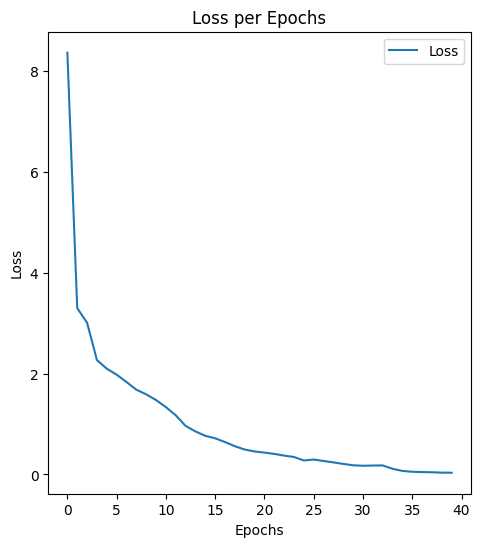

In [49]:
loss_history = history.history['loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss')
plt.title('Loss per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Prediction

In [46]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

In [47]:
predictions = []
targets = []
for batch in val_ds:
    X, y = batch
    batch_predictions = model.predict(X, verbose=0)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)

In [22]:
def calculate_acc(y_true, y_pred):
  acc = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
  return acc

In [48]:
calculate_acc(predictions, targets)

0.8641304347826086